#Install required libraries

<div dir=rtl>
در این سلول، کتابخانه های مورد نیاز بترتیب برای پیش پردازش متن ها و نیز ایجاد اپتیمایزر نصب میشوند.
</div>

In [1]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.6 MB 5.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.9 kB/s 
     |████████████████████████████████| 5.8 MB 39.6 MB/s 
     |████████████████████████████████| 438 kB 67.4 MB/s 
     |████████████████████████████████| 1.6 MB 58.3 MB/s 
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
     |████████████████████████████████| 92 kB 14.6 MB/s 
     |████████████████████████████████| 352 kB 68.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 636 kB 59.1 MB/s 
     |████████████████████████████████| 99 kB 12.3 MB/s 
     |████████████████████████████████| 1.2 MB 54.5 MB/s 
     |████████████████████████████████| 237 kB 71.2 MB/s 


#Import required libraries

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  

import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random
tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Download dataset

<div dir=rtl>
داده ها در ابتدا دانلود شده و پس از استخراج از حالت فشرده، 50 هزار نمونه برای ترین و 10 هزار نمونه برای تست انتخاب میشود.
</div>

In [3]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
!tar -xvzf yelp_review_polarity_csv.tgz

train_data = pd.read_csv('yelp_review_polarity_csv/train.csv', header = None)
test_data = pd.read_csv('yelp_review_polarity_csv/test.csv', header = None)

X_train = train_data[1].values[:50000]
y_train = train_data[0].values[:50000]

X_test = test_data[1].values[:10000]
y_test = test_data[0].values[:10000]

--2022-07-02 20:15:28--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.192.200
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.192.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  57.7MB/s    in 2.7s    

2022-07-02 20:15:31 (57.7 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


#Preprcessing data

In [4]:
def text_lowercase(text):
    return text.lower()

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespace(text):
    return  " ".join(text.split())

def remove_stopwords(text):
    stop_words = list(set(stopwords.words("english")))
    word_tokens = word_tokenize(text)
    filtered_text = "".join(w + " " for w in word_tokens if w not in stop_words)
    return filtered_text.strip()


X_train = np.array(list(map(lambda a: text_lowercase(a), X_train)))
X_train = np.array(list(map(lambda a: remove_numbers(a), X_train)))
X_train = np.array(list(map(lambda a: remove_punctuation(a), X_train)))
X_train = np.array(list(map(lambda a: remove_whitespace(a), X_train)))
X_train = np.array(list(map(lambda a: remove_stopwords(a), X_train)))

X_test = np.array(list(map(lambda a: text_lowercase(a), X_test)))
X_test = np.array(list(map(lambda a: remove_numbers(a), X_test)))
X_test = np.array(list(map(lambda a: remove_punctuation(a), X_test)))
X_test = np.array(list(map(lambda a: remove_whitespace(a), X_test)))
X_test = np.array(list(map(lambda a: remove_stopwords(a), X_test)))

y_train = y_train - 1
y_test = y_test - 1

train_inds = list(range(len(X_train)))
random.shuffle(train_inds)

val_inds = train_inds[:int(0.2 * len(X_train))]
train_inds = train_inds[int(0.2 * len(X_train)):]

X_val = X_train[val_inds]
y_val = y_train[val_inds]

X_train = X_train[train_inds]
y_train = y_train[train_inds]

#Data prepration

<div dir=rtl>
داده ها از آرایه به داده های با فرمت تنسور تبدیل میشوند
</div>

In [5]:
batch_size = 64

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

#Download bert preprocess model layer from tensorflow hub

<div dir=rtl>
در این سلول لایه ای از طبقه بند دانلود میشود که بوسیله آن به هر کلمه یک آیدی یکتا تخصیص داده میشود. بنابراین جملات ورودی به این لایه تبدیل به برداری میشوند که این بردار به تعداد کلمات جمله ورودی، عدد صحیح غیر صفر دارد و هر کدام از این اعداد صحیح صرفا مختص یک کلمه هستند.
</div>

In [6]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#Print a sample of vectorized texts (first 12 from each vector)

<div dir=rtl>
در این سلول کاربرد لایه دانلود شده در سلول قبلی نشان داده شده است.
</div>

In [7]:
text_test = ['I am very sad']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 2200 6517  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#Download a pretrained layer of bert model from tensorflow hub


<div dir=rtl>
در این سلول لایه برت آموزش دیده دانلود میشود. این لایه وظیفه ایجاد بردار امبدینگ جملات تبدیل شده به بردار اعداد صحیح را دارد.
</div>

In [8]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

#Print a sample of embeddong 

<div dir=rtl>
در این سلول یک نمونه از تبدیل بردار اعداد صحیح یه جمله به بردار امبدینگ نمایش داده شده است.
</div>

In [9]:
bert_results = bert_model(text_preprocessed)
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 6.4421439e-01  8.3998489e-01 -5.9660041e-04  3.6334994e-01
  1.9543417e-02  9.8199868e-01  9.9973828e-01 -8.4613484e-01
 -2.6827723e-01 -9.9975228e-01  4.4512892e-01 -9.9474567e-01]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.4264921  -0.07664166  0.47126234 ... -1.9925171  -0.10882223
   0.21042255]
 [ 0.53082246  0.35606366  0.25034866 ... -1.407059    0.08821574
  -0.40133435]
 [ 0.21216527  0.35808447 -0.2600027  ... -1.5148194  -0.99928594
  -0.3359062 ]
 ...
 [ 0.36093473 -0.7267612  -0.5357293  ... -0.97871506  0.25719464
   0.25364357]
 [ 0.49925643 -0.48690543 -0.3228518  ... -1.0170404   0.3102335
  -0.10544414]
 [ 0.26277962 -0.45932132 -0.1052995  ... -0.8812504   0.5005714
   0.19059947]]


#Classifier definition

<div dir=rtl>
در این سلول معماری طبقه بند ایجاد شده است. همانطور که مشخص است، در ابتدا یک لایه ورودی ایجاد شده است، سپس لایه تبدیل جمله به بردار اعداد صحیح ایجاد شده است، سپس لایه امبدینگ توسط برت اضافه شده استو در نهایت یک لایه دراپ اوت و تمام متصل اضافه شده و ایجاد معماری مدل به اتمام رسیده است.
</div>

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

#Initialization classifier

<div dir=rtl>
در این سلول خروجی شبکه به ازای متن نمونه و تابع فعالساز خروجی سیگمویید نشان داده شده است.
</div>

In [11]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.56267023]], shape=(1, 1), dtype=float32)


#Print model diagram

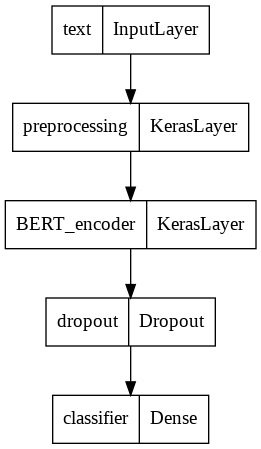

In [ ]:
tf.keras.utils.plot_model(classifier_model)

# Loss function and optimizer definition

<div dir=rtl>
در این سلول به ترتیب تعداد دوره های آموزش شبکه، مقدار اولیه نرخ آموزش، تعداد گام ها در هر دوره آموزش، تعداد کل گام های آموزش، تعداد گام های وارم آپ (تعداد گام های وارم آپ تعداد دفعات آپدیت نرخ آموزش را تعیین میکند)، تابع هزینه (با توجه به تعداد نورون های لایه خروجی، از نوع باینری میباشد)، متریک برای تعیین پرفرومنس مدل در هنگام آموزش و تست و بهینه سازتعیین شده است
</div>

In [14]:
epochs = 2
init_lr = 3e-5
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

loss = tf.keras.losses.Poisson()
metrics = tf.metrics.BinaryAccuracy()

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='lamb')

#Model compile and train

In [15]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_data,
                               validation_data=val_data,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
625/625 [==============================] - 343s 529ms/step - loss: 0.7208 - binary_accuracy: 0.7330 - val_loss: 0.6308 - val_binary_accuracy: 0.8597
Epoch 2/2
625/625 [==============================] - 328s 524ms/step - loss: 0.6237 - binary_accuracy: 0.8622 - val_loss: 0.6142 - val_binary_accuracy: 0.8781


#Plot history

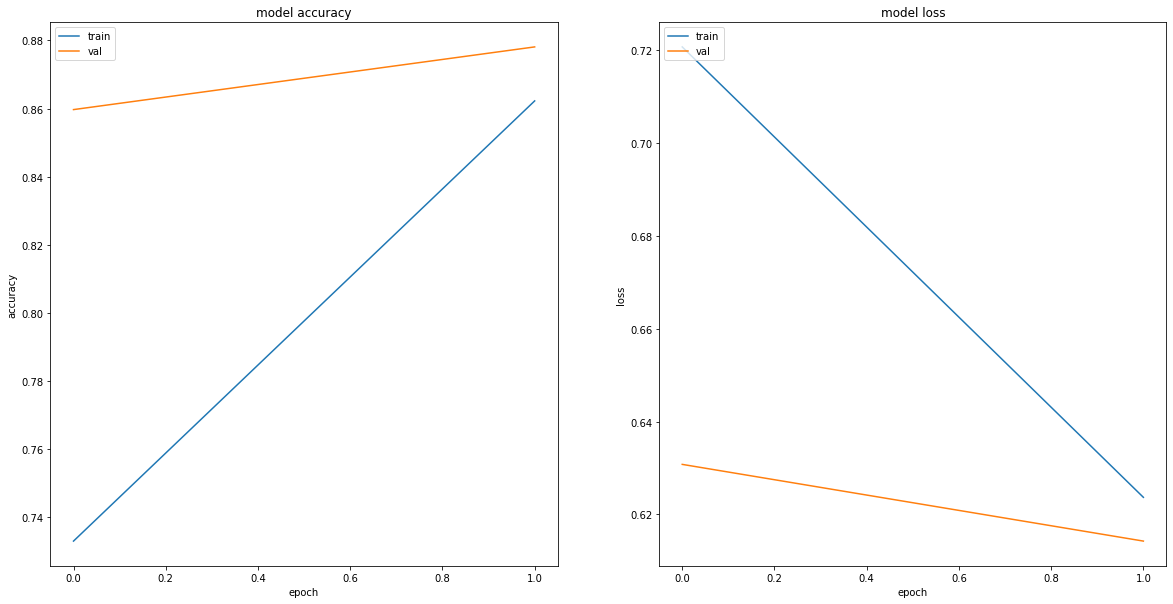

In [16]:
from matplotlib import pyplot as plt

fix, ax = plt.subplots(1,2, figsize = (20, 10))

ax[0].plot(history.history['binary_accuracy'])
ax[0].plot(history.history['val_binary_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

#Model evaluation

In [17]:
def round_func(n):
    if n < 0.5:
        return 0
    else:
        return 1

In [18]:
preds = classifier_model.predict(test_data)
preds = preds.reshape(1, -1)[0]
preds = np.array(list(map(lambda a:round_func(a), preds)))

157/157 [==============================] - 39s 246ms/step


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5367
    positive       0.85      0.87      0.86      4633

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

